# Exploration of the data for orly take off and landings

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm 

from traffic.core import Traffic,Flight

/tmp/ipykernel_236704/615996726.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Getting the data

### LFPO6

In [2]:
%matplotlib inline

In [3]:
from typing import Iterator, Optional

import pandas as pd

from traffic.core import Flight, Traffic


def aligned_stats(traj: "Flight") -> Optional[pd.DataFrame]:
    from traffic.data import navaids

    navaids_extent = navaids.extent(traj, buffer=0.1)
    if navaids_extent is None:
        return None

    df = pd.DataFrame.from_records(
        list(
            {
                "start": segment.start,
                "stop": segment.stop,
                "duration": segment.duration,
                "navaid": segment.max("navaid"),
                "distance": segment.min("distance"),
                "bdiff_mean": segment.data[
                    "shift"
                ].mean(),  # b_diff_mean is equivalent to shift.mean() now ?
                "bdiff_meanp": segment.data["shift"].mean() + 0.02,
            }
            for segment in traj.aligned_on_navpoint(
                list(navaids_extent.drop_duplicates("name"))
            )
        )
    )

    if df.shape[0] == 0:
        return None
    return df.sort_values("start")


def groupby_intervals(table: pd.DataFrame) -> "Iterator[pd.DataFrame]":
    if table.shape[0] == 0:
        return
    table = table.sort_values("start")
    sweeping_line = table.query(
        "stop <= stop.iloc[0]"
    )  # take as much as you can
    # then try to push the stop line: which intervals overlap the stop line
    additional = table.query("start <= @sweeping_line.stop.max() < stop")

    while additional.shape[0] > 0:
        sweeping_line = table.query("stop <= @additional.stop.max()")
        additional = table.query("start <= @sweeping_line.stop.max() < stop")

    yield sweeping_line
    yield from groupby_intervals(
        table.query("start > @sweeping_line.stop.max()")
    )

In [4]:
def reconstruct_navpoints(traj: "Flight") -> "Iterator[pd.DataFrame]":
    table = aligned_stats(traj)
    if table is None:
        return
    for block in groupby_intervals(table):
        t_threshold = block.eval("duration.max()") - pd.Timedelta(  # noqa: F841
            "30s"
        )
        yield block.sort_values("bdiff_mean").query(
            "duration >= @t_threshold"
        ).head(1)

In [5]:
def navpoints_table(flight: "Flight") -> Optional["Flight"]:
    from traffic.data import navaids

    navaids_extent = navaids.extent(flight, buffer=0.1)
    if navaids_extent is None:
        return None

    list_ = list(reconstruct_navpoints(flight))
    if len(list_) == 0:
        print(f"fail with {flight.flight_id}")
        return None

    navpoints_table = pd.concat(list(reconstruct_navpoints(flight))).merge(
        navaids_extent.drop_duplicates("name").data,
        left_on="navaid",
        right_on="name",
    )

    cd_np = navaids_extent.drop_duplicates("name")

    try_list = list(
        (i, cd_np[elt.navaid], elt.stop, elt.duration)
        for i, elt in navpoints_table.assign(
            delta=lambda df: df.start.shift(-1) - df.stop
        )
        .drop(
            columns=[
                "altitude",
                "frequency",
                "magnetic_variation",
                "description",
            ]
        )
        .query('delta > "30s"')
        .iterrows()
    )
    for i, fix, stop, duration in try_list:
        cd = (
            flight.after(stop)
            .first(duration)  # type: ignore
            .assign(track=lambda df: df.track + 180)
            .aligned_on_navpoint([fix])
            .next()
        )
        if cd is not None:

            navpoints_table.loc[i, ["stop", "distance"]] = (
                cd.stop,
                -cd.distance_max,
            )

    return Flight(
        navpoints_table.assign(
            flight_id=flight.flight_id,
            callsign=flight.callsign,
            icao24=flight.icao24,
            registration=flight.registration,
            typecode=flight.typecode,
            #runway=flight.runway_max,
            coverage=navpoints_table.duration.sum().total_seconds()
            / flight.duration.total_seconds(),
            latitude_0=flight.at_ratio(0).latitude,  # type: ignore
            longitude_0=flight.at_ratio(0).longitude,  # type: ignore
            altitude_0=flight.at_ratio(0).altitude,  # type: ignore
            track_0=flight.at_ratio(0).track,  # type: ignore
            groundspeed_0=flight.at_ratio(0).groundspeed,  # type: ignore
        ).drop(
            columns=[
                "bdiff_mean",
                "bdiff_meanp",
                "frequency",
                "magnetic_variation",
                "description",
                "altitude",
            ]
        )
    )


In [6]:
from traffic.data import navaids

In [7]:
from cartes.crs import Lambert93

In [49]:
def plot_traffic(
        traffic: Traffic,
        plot_path: str,
        nav: list,
        background: bool = True,
        
    ) -> None:


        with plt.style.context("traffic"):
            fig, ax = plt.subplots(subplot_kw=dict(projection=Lambert93()))
            traffic.plot(ax, alpha=0.7, color="#4c78a8")
            for nav_i in nav:
                  nav_i.plot(ax)
            plt.savefig(plot_path)
            plt.show()

In [113]:
import sys  # noqa: I001
import os

current_path = os.getcwd()
sys.path.append(
    os.path.abspath(current_path)
)

print("Current working directory:", current_path)


from data_orly.src.generation.data_process import Data_cleaner

Current working directory: /home/arnault/traffic/data_orly/sandbox


ModuleNotFoundError: No module named 'data_orly'

In [9]:
flight = landings_orly_6[0]

NameError: name 'landings_orly_6' is not defined

In [98]:
flight.data.head(1)

,timestamp,altitude,callsign,groundspeed,icao24,latitude,longitude,origin,squawk,track,vertical_rate,flight_id,distance,track_unwrapped,x,y,timedelta
0,2022-07-27 20:47:50+00:00,11100.0,17LQ,375.0,3453c3,48.158243,1.486323,LPPT,1162,34.028841,-1600.0,17LQ_000,47.315521,34.028841,-58618.219509,5361355.06863,0


In [52]:
limited = flight.data[["latitude","longitude","timestamp","icao24"]]
limited.dtypes

latitude                    double[pyarrow]
longitude                   double[pyarrow]
timestamp    timestamp[ns, tz=UTC][pyarrow]
icao24                      string[pyarrow]
dtype: object

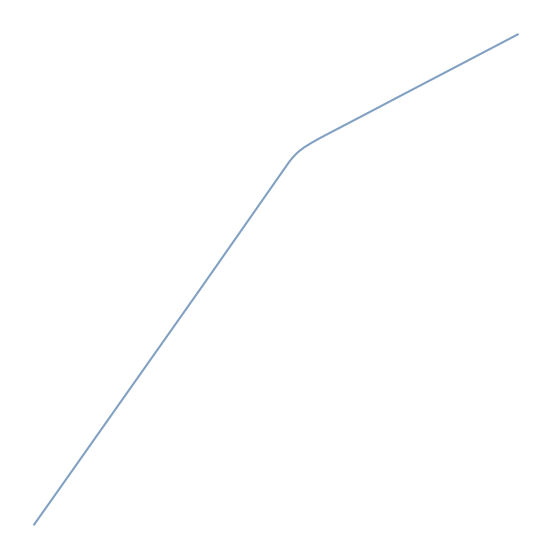

In [106]:
plot_traffic(Traffic(limited),"ttezt.png")

In [ ]:
plot_traffic(landings_orly_6[:1],'ttt.png')

In [87]:
flight.data.dtypes

timestamp          timestamp[ns, tz=UTC][pyarrow]
altitude                          double[pyarrow]
callsign                          string[pyarrow]
groundspeed                       double[pyarrow]
icao24                            string[pyarrow]
latitude                          double[pyarrow]
longitude                         double[pyarrow]
origin                            string[pyarrow]
squawk                            string[pyarrow]
track                             double[pyarrow]
vertical_rate                     double[pyarrow]
flight_id                         string[pyarrow]
distance                          double[pyarrow]
track_unwrapped                   double[pyarrow]
x                                 double[pyarrow]
y                                 double[pyarrow]
timedelta                          int64[pyarrow]
dtype: object

In [3]:
landings_orly_6 = Traffic.from_file("/home/arnault/traffic/data_orly/data/landings_LFPO_06.pkl")

In [9]:
from cartopy.crs import EuroPP

In [10]:
landings_orly_6 = landings_orly_6.compute_xy(EuroPP())

In [17]:
f = landings_orly_6[1]

In [20]:
f.data

,timestamp,altitude,callsign,groundspeed,icao24,latitude,longitude,origin,squawk,track,vertical_rate,flight_id,distance,track_unwrapped,x,y,timedelta
0,2022-07-10 15:25:28+00:00,10425.0,A7MBK,295.0,06a0a4,48.17157,3.293574,LOWW,1000,297.867004,-1408.0,A7MBK_001,51.052094,297.867004,75797.253992,5.351240e+06,0
1,2022-07-10 15:25:34+00:00,10425.0,A7MBK,295.0,06a0a4,48.175781,3.281673,LOWW,1000,297.69517,-1344.0,A7MBK_001,50.524623,297.69517,74947.737604,5.351774e+06,6
2,2022-07-10 15:25:38+00:00,10425.0,A7MBK,294.0,06a0a4,48.178391,3.274278,LOWW,1000,297.613028,-1344.0,A7MBK_001,50.197338,297.613028,74419.946672,5.352104e+06,10
3,2022-07-10 15:25:44+00:00,10425.0,A7MBK,293.0,06a0a4,48.181881,3.264222,LOWW,1000,297.613028,-1408.0,A7MBK_001,49.754738,297.613028,73701.850043,5.352548e+06,16
4,2022-07-10 15:25:48+00:00,10337.5,A7MBK,293.0,06a0a4,48.184391,3.257085,LOWW,1000,297.613028,-1408.0,A7MBK_001,49.439449,297.613028,73192.470137,5.352867e+06,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2022-07-10 15:41:46+00:00,925.0,A7MBK,135.0,06a0a4,48.698547,2.256493,LOWW,1000,61.727964,-704.0,A7MBK_001,2.725021,421.727964,3918.176129,5.416031e+06,978
196,2022-07-10 15:41:50+00:00,875.0,A7MBK,135.0,06a0a4,48.699738,2.259874,LOWW,1000,61.727964,-704.0,A7MBK_001,2.572838,421.727964,4178.438690,5.416141e+06,982
197,2022-07-10 15:41:56+00:00,825.0,A7MBK,133.0,06a0a4,48.701508,2.264846,LOWW,1000,61.699244,-704.0,A7MBK_001,2.348426,421.699244,4561.444853,5.416306e+06,988
198,2022-07-10 15:42:00+00:00,775.0,A7MBK,133.0,06a0a4,48.702713,2.268184,LOWW,1000,61.699244,-640.0,A7MBK_001,2.197323,421.699244,4818.690730,5.416418e+06,992


In [18]:
t = f.resample(50)

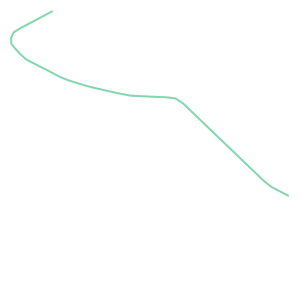

In [19]:
t

In [ ]:
landings_orly_6 = landings_orly_6.aircraft_data()

In [8]:
landings_orly_6.data.head(2)

,timestamp,altitude,callsign,groundspeed,icao24,latitude,longitude,origin,squawk,track,vertical_rate,flight_id,distance,track_unwrapped,x,y,timedelta,registration,typecode
0,2022-07-27 20:47:50+00:00,11100.0,17LQ,375.0,3453c3,48.158243,1.486323,LPPT,1162,34.028841,-1600.0,17LQ_000,47.315521,34.028841,-58618.219509,5361355.06863,0,EC-MRF,A321
1,2022-07-27 20:47:54+00:00,11100.0,17LQ,374.0,3453c3,48.164202,1.492406,LPPT,1162,34.159695,-1600.0,17LQ_000,46.888796,34.159695,-58101.331146,5361972.360065,4,EC-MRF,A321


In [5]:
flight = landings_orly_6[0]

In [71]:
gen_2 = reconstruct_navpoints(flight)

In [54]:
for e in gen_2:
    print(e)

                       start                      stop        duration navaid  \
21 2022-07-27 20:47:50+00:00 2022-07-27 20:53:34+00:00 0 days 00:05:44  PO611   

    distance  bdiff_mean  bdiff_meanp  
21  0.864401    0.034358     0.054358  
                      start                      stop        duration navaid  \
7 2022-07-27 20:54:08+00:00 2022-07-27 20:59:20+00:00 0 days 00:05:12  D254D   

   distance  bdiff_mean  bdiff_meanp  
7  0.778256     0.02813      0.04813  


In [86]:
from datetime import datetime
flight.data[120:]

,timestamp,altitude,callsign,groundspeed,icao24,latitude,longitude,origin,squawk,track,vertical_rate,flight_id,distance,track_unwrapped,x,y,timedelta
120,2022-07-27 20:54:46+00:00,4800.0,17LQ,229.0,3453c3,48.608357,2.003704,LPPT,1162,61.52953,-1536.0,17LQ_000,14.147128,61.52953,-15588.904729,5407697.409514,416
121,2022-07-27 20:54:50+00:00,4700.0,17LQ,227.0,3453c3,48.610382,2.009301,LPPT,1162,61.630954,-1536.0,17LQ_000,13.89326,61.630954,-15156.01616,5407884.364639,420
122,2022-07-27 20:54:54+00:00,4625.0,17LQ,226.0,3453c3,48.612259,2.014583,LPPT,1162,61.733594,-1472.0,17LQ_000,13.654666,61.733594,-14747.874083,5408057.02639,424
123,2022-07-27 20:54:56+00:00,4550.0,17LQ,226.0,3453c3,48.61322,2.017259,LPPT,1162,61.733594,-1472.0,17LQ_000,13.533485,61.733594,-14540.986925,5408145.671282,426
124,2022-07-27 20:55:00+00:00,4475.0,17LQ,224.0,3453c3,48.61534,2.023147,LPPT,1162,61.491526,-1408.0,17LQ_000,13.266743,61.491526,-14085.784484,5408341.246924,430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2022-07-27 20:59:06+00:00,1050.0,17LQ,129.0,3453c3,48.700717,2.262605,LPPT,1162,61.849311,-704.0,17LQ_000,2.449365,61.849311,4388.923132,5416232.398432,676
196,2022-07-27 20:59:10+00:00,975.0,17LQ,129.0,3453c3,48.701927,2.266075,LPPT,1162,62.241459,-704.0,17LQ_000,2.293499,62.241459,4655.903454,5416344.192876,680
197,2022-07-27 20:59:14+00:00,950.0,17LQ,128.0,3453c3,48.702942,2.268888,LPPT,1162,62.032884,-704.0,17LQ_000,2.166162,62.032884,4872.716925,5416438.560828,684
198,2022-07-27 20:59:16+00:00,925.0,17LQ,128.0,3453c3,48.703537,2.270578,LPPT,1162,62.032884,-704.0,17LQ_000,2.090075,62.032884,5002.828633,5416493.637063,686


In [72]:
nav_1 = [e for e in gen_2]


In [73]:
nav_1

[                       start                      stop        duration navaid  \
 21 2022-07-27 20:47:50+00:00 2022-07-27 20:53:34+00:00 0 days 00:05:44  PO611   
 
     distance  bdiff_mean  bdiff_meanp  
 21  0.864401    0.034358     0.054358  ,
                       start                      stop        duration navaid  \
 7 2022-07-27 20:54:08+00:00 2022-07-27 20:59:20+00:00 0 days 00:05:12  D254D   
 
    distance  bdiff_mean  bdiff_meanp  
 7  0.778256     0.02813      0.04813  ]

In [74]:
nav = [e["navaid"].iloc[0] for e in nav_1]
#nav = [navaids[e] for e in nav]

In [75]:
print(nav)

['PO611', 'D254D']


In [76]:
useful_nav = navaids.extent(flight, buffer=0.1).drop_duplicates("name")

In [77]:
navigation_points = [useful_nav[e] for e in nav]

In [78]:
navigation_points

[Navaid('PO611', type='FIX', latitude=48.57608333, longitude=1.91380556),
 Navaid('D254D', type='FIX', latitude=48.71088333, longitude=2.29090556)]

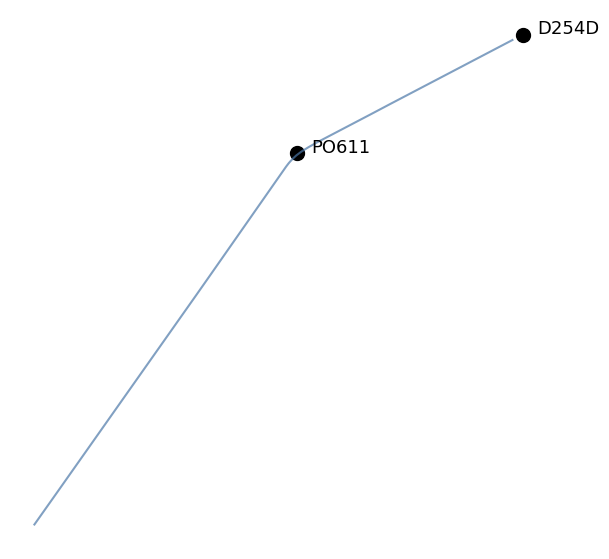

In [79]:
plot_traffic(Traffic(flight.data),'alors.png',nav=navigation_points)

In [28]:
from traffic.data import navaids

In [29]:
navaids["PO611"]

Navaid('PO611', type='FIX', latitude=48.57608333, longitude=1.91380556)

In [80]:
f=navpoints_table(flight)

In [82]:
f.data

,start,stop,duration,navaid,distance,name,type,latitude,longitude,flight_id,callsign,icao24,registration,typecode,coverage,latitude_0,longitude_0,altitude_0,track_0,groundspeed_0
0,2022-07-27 20:47:50+00:00,2022-07-27 20:59:16+00:00,0 days 00:05:44,PO611,-16.128545,PO611,FIX,48.576083,1.913806,17LQ_000,17LQ,3453c3,EC-MRF,A321,0.950725,48.158243,1.486323,11100.0,34.028841,375.0
1,2022-07-27 20:54:08+00:00,2022-07-27 20:59:20+00:00,0 days 00:05:12,D254D,0.778256,D254D,FIX,48.710883,2.290906,17LQ_000,17LQ,3453c3,EC-MRF,A321,0.950725,48.158243,1.486323,11100.0,34.028841,375.0


In [83]:
from datetime import timedelta
def convert_time_delta_to_start_str(time_delta: int) -> str:
    time = str(timedelta(seconds=time_delta))
    return time + ">"

In [ ]:
def create_scn_line(
    command: str, data: pd.Series, typecode: bool = False
) -> str:
    time = data["timedelta"]
    time_str = convert_time_delta_to_start_str(time)
    plane_id = f"AC{data['flight_id']}"
    line = f"{time_str} {command} {plane_id},"
    heading = data["track"]
    if typecode:
        line += f" {data['aircraft']},"
    line += f" {data['latitude']}, {data['longitude']}, {heading}, {data['altitude']}, {data['groundspeed']}"
    return line

In [80]:
f.data

,start,stop,duration,navaid,distance,name,type,latitude,longitude,flight_id,callsign,icao24,registration,typecode,coverage,latitude_0,longitude_0,altitude_0,track_0,groundspeed_0
0,2022-07-27 20:47:50+00:00,2022-07-27 20:59:16+00:00,0 days 00:05:44,PO611,-16.128545,PO611,FIX,48.576083,1.913806,17LQ_000,17LQ,3453c3,EC-MRF,A321,0.950725,48.158243,1.486323,11100.0,34.028841,375.0
1,2022-07-27 20:54:08+00:00,2022-07-27 20:59:20+00:00,0 days 00:05:12,D254D,0.778256,D254D,FIX,48.710883,2.290906,17LQ_000,17LQ,3453c3,EC-MRF,A321,0.950725,48.158243,1.486323,11100.0,34.028841,375.0


In [81]:
def turn_scn(f:Flight) -> pd.DataFrame:
    text = ""
    data = f.data
    flight_data = {
        "flight_id": [data.loc[0, 'flight_id']],
        "aircraft" : ["A320"],
        "time": [data.loc[0, 'start']],
        "track": [data.loc[0, 'track_0']],
        "latitude": [data.loc[0, 'latitude_0']],
        "longitude": [data.loc[0, 'longitude_0']],
        "altitude": [data.loc[0, 'altitude_0']],
        "groundspeed": [data.loc[0, "groundspeed_0"]],
        "way_point" : [None]
        
    }

    for i,row in data.iterrows():
        flight_data["flight_id"].append(row["flight_id"])
        flight_data["aircraft"].append(None)
        flight_data["time"].append(row["start"]+row["duration"])
        flight_data["track"].append(None)
        flight_data["latitude"].append(row["latitude"])
        flight_data["longitude"].append(row["longitude"])
        flight_data["altitude"].append(None)
        flight_data["groundspeed"].append(None)
        flight_data["way_point"].append(row["navaid"])

    return pd.DataFrame(flight_data)

    


In [82]:
scn = turn_scn(f)

In [83]:
def scenario(data:pd.DataFrame)-> str:
    text = ""
    for i,row in data.iterrows():
        time = convert_time_delta_to_start_str(0)
        id = row["flight_id"]
        if row["way_point"] is None:
            text += f'{time}CRE {id}, {row["aircraft"]}, {row["latitude"]}, {row["longitude"]}, {row["track"]}, {row["groundspeed"]} \n'
        else :
            text+=f'{time}ADDWPT {id} {row["latitude"]} {row["longitude"]} \n'
    return text

    

In [84]:
txt = scenario(scn)

In [85]:
with open("testons_scn.scn","w") as f:
    f.write(txt)

In [32]:
flight.data

,timestamp,altitude,callsign,groundspeed,icao24,latitude,longitude,origin,squawk,track,vertical_rate,flight_id,distance,track_unwrapped,x,y,timedelta
0,2022-07-27 20:47:50+00:00,11100.0,17LQ,375.0,3453c3,48.158243,1.486323,LPPT,1162,34.028841,-1600.0,17LQ_000,47.315521,34.028841,-58618.219509,5361355.06863,0
1,2022-07-27 20:47:54+00:00,11100.0,17LQ,374.0,3453c3,48.164202,1.492406,LPPT,1162,34.159695,-1600.0,17LQ_000,46.888796,34.159695,-58101.331146,5361972.360065,4
2,2022-07-27 20:47:56+00:00,11100.0,17LQ,374.0,3453c3,48.167088,1.495297,LPPT,1162,34.159695,-1600.0,17LQ_000,46.6837,34.159695,-57855.090588,5362271.775864,6
3,2022-07-27 20:48:00+00:00,11100.0,17LQ,372.0,3453c3,48.17244,1.500761,LPPT,1162,34.159695,-1408.0,17LQ_000,46.30064,34.159695,-57390.944327,5362826.172853,10
4,2022-07-27 20:48:04+00:00,11100.0,17LQ,371.0,3453c3,48.178354,1.506789,LPPT,1162,34.118599,-1088.0,17LQ_000,45.877677,34.118599,-56878.765677,5363439.034793,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2022-07-27 20:59:06+00:00,1050.0,17LQ,129.0,3453c3,48.700717,2.262605,LPPT,1162,61.849311,-704.0,17LQ_000,2.449365,61.849311,4388.923132,5416232.398432,676
196,2022-07-27 20:59:10+00:00,975.0,17LQ,129.0,3453c3,48.701927,2.266075,LPPT,1162,62.241459,-704.0,17LQ_000,2.293499,62.241459,4655.903454,5416344.192876,680
197,2022-07-27 20:59:14+00:00,950.0,17LQ,128.0,3453c3,48.702942,2.268888,LPPT,1162,62.032884,-704.0,17LQ_000,2.166162,62.032884,4872.716925,5416438.560828,684
198,2022-07-27 20:59:16+00:00,925.0,17LQ,128.0,3453c3,48.703537,2.270578,LPPT,1162,62.032884,-704.0,17LQ_000,2.090075,62.032884,5002.828633,5416493.637063,686


In [25]:
f.data["timestamp"] =f.data["start"]

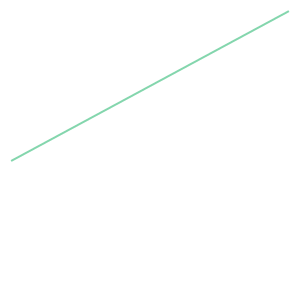

In [27]:
f

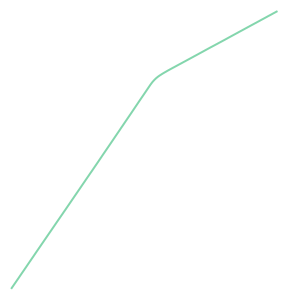

In [11]:
flight

In [6]:
df = aligned_stats(flight)

In [10]:
df.sort_values("start")

,start,stop,duration,navaid,distance,bdiff_mean,bdiff_meanp
0,2022-07-27 20:47:50+00:00,2022-07-27 20:48:36+00:00,0 days 00:00:46,20DME,37.174931,0.661030,0.681030
8,2022-07-27 20:47:50+00:00,2022-07-27 20:49:00+00:00,0 days 00:01:10,D350A,37.084890,0.593264,0.613264
4,2022-07-27 20:47:50+00:00,2022-07-27 20:53:30+00:00,0 days 00:05:40,D034G,13.514457,0.058399,0.078399
9,2022-07-27 20:47:50+00:00,2022-07-27 20:53:30+00:00,0 days 00:05:40,DER25,13.981174,0.149229,0.169229
14,2022-07-27 20:47:50+00:00,2022-07-27 20:48:36+00:00,0 days 00:00:46,ODILO,1.354586,0.020365,0.040365
12,2022-07-27 20:47:50+00:00,2022-07-27 20:50:46+00:00,0 days 00:02:56,INPER,0.943143,0.013063,0.033063
15,2022-07-27 20:47:50+00:00,2022-07-27 20:48:36+00:00,0 days 00:00:46,PN510,37.357048,0.676421,0.696421
19,2022-07-27 20:47:50+00:00,2022-07-27 20:50:40+00:00,0 days 00:02:50,PO604,1.359256,0.014113,0.034113
5,2022-07-27 20:47:50+00:00,2022-07-27 20:53:30+00:00,0 days 00:05:40,D035G,13.514859,0.099612,0.119612
21,2022-07-27 20:47:50+00:00,2022-07-27 20:53:34+00:00,0 days 00:05:44,PO611,0.864401,0.034358,0.054358


In [7]:
gen = groupby_intervals(df)

In [8]:
for e in gen:
    print(e)

                       start                      stop        duration navaid  \
0  2022-07-27 20:47:50+00:00 2022-07-27 20:48:36+00:00 0 days 00:00:46  20DME   
8  2022-07-27 20:47:50+00:00 2022-07-27 20:49:00+00:00 0 days 00:01:10  D350A   
4  2022-07-27 20:47:50+00:00 2022-07-27 20:53:30+00:00 0 days 00:05:40  D034G   
9  2022-07-27 20:47:50+00:00 2022-07-27 20:53:30+00:00 0 days 00:05:40  DER25   
14 2022-07-27 20:47:50+00:00 2022-07-27 20:48:36+00:00 0 days 00:00:46  ODILO   
12 2022-07-27 20:47:50+00:00 2022-07-27 20:50:46+00:00 0 days 00:02:56  INPER   
15 2022-07-27 20:47:50+00:00 2022-07-27 20:48:36+00:00 0 days 00:00:46  PN510   
19 2022-07-27 20:47:50+00:00 2022-07-27 20:50:40+00:00 0 days 00:02:50  PO604   
5  2022-07-27 20:47:50+00:00 2022-07-27 20:53:30+00:00 0 days 00:05:40  D035G   
21 2022-07-27 20:47:50+00:00 2022-07-27 20:53:34+00:00 0 days 00:05:44  PO611   
22 2022-07-27 20:47:50+00:00 2022-07-27 20:52:34+00:00 0 days 00:04:44  VASOL   
23 2022-07-27 20:47:50+00:00

In [20]:
navaids_ext = navaids.extent(flight,buffer = 0.1)

In [21]:
navaids_ext

,name,type,latitude,longitude,altitude,frequency,magnetic_variation,description
15198,20DM2,FIX,48.763492,2.157597,NaN,NaN,NaN,None
15208,20DME,FIX,48.741011,2.062981,NaN,NaN,NaN,None
23717,30VO2,FIX,48.684575,2.354525,NaN,NaN,NaN,None
25992,33LOC,FIX,48.710753,2.311769,NaN,NaN,NaN,None
31836,40THR,FIX,48.689783,2.231803,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...
285290,VVE,DME,48.775722,2.193583,640.0,111.35,NaN,LFPV 09 DME-ILS
285291,VVO,DME,48.775611,2.209889,635.0,110.75,NaN,LFPV 27 DME-ILS
287184,CAD,DME,48.059167,1.387083,456.0,115.95,NaN,CHATEAUDUN VOR-DME
287677,EPR,DME,48.625694,1.656556,604.0,115.65,NaN,EPERNON VOR-DME


In [22]:
df = pd.DataFrame.from_records(
        list(
            {
                "start": segment.start,
                "stop": segment.stop,
                "duration": segment.duration,
                "navaid": segment.max("navaid"),
                "distance": segment.min("distance"),
                "bdiff_mean": segment.data[
                    "shift"
                ].mean(),  # b_diff_mean is equivalent to shift.mean() now ?
                "bdiff_meanp": segment.data["shift"].mean() + 0.02,
            }
            for segment in flight.aligned_on_navpoint(
                list(navaids_ext.drop_duplicates("name"))
            )
        )
    )

In [29]:
for seg in flight.aligned_on_navpoint(
                list(navaids_ext.drop_duplicates("name"))
):
    print(seg.data["navaid"])
    print(seg.max("navaid"))
    print(seg.data["navaid"].mode()[0])

0     20DME
5     20DME
6     20DME
7     20DME
8     20DME
13    20DME
Name: navaid, dtype: object
20DME
20DME
109    40THR
110    40THR
111    40THR
112    40THR
113    40THR
       ...  
179    40THR
180    40THR
181    40THR
182    40THR
183    40THR
Name: navaid, Length: 75, dtype: object
40THR
40THR
108    61LOC
109    61LOC
110    61LOC
111    61LOC
112    61LOC
129    61LOC
130    61LOC
Name: navaid, dtype: object
61LOC
61LOC
109    CI06
110    CI06
111    CI06
112    CI06
113    CI06
114    CI06
115    CI06
116    CI06
117    CI06
118    CI06
119    CI06
Name: navaid, dtype: object
CI06
CI06
0     D034G
1     D034G
2     D034G
3     D034G
4     D034G
      ...  
94    D034G
95    D034G
96    D034G
97    D034G
98    D034G
Name: navaid, Length: 99, dtype: object
D034G
D034G
0     D035G
1     D035G
2     D035G
3     D035G
4     D035G
      ...  
94    D035G
95    D035G
96    D035G
97    D035G
98    D035G
Name: navaid, Length: 99, dtype: object
D035G
D035G
111    D250D
112    D250

In [30]:
max("61LOC","OLO")

'OLO'

In [23]:
df.sort_values("start")

,start,stop,duration,navaid,distance,bdiff_mean,bdiff_meanp
0,2022-07-27 20:47:50+00:00,2022-07-27 20:48:36+00:00,0 days 00:00:46,20DME,37.174931,0.661030,0.681030
26,2022-07-27 20:47:50+00:00,2022-07-27 20:53:30+00:00,0 days 00:05:40,TNO,13.737283,0.061200,0.081200
25,2022-07-27 20:47:50+00:00,2022-07-27 20:53:30+00:00,0 days 00:05:40,TSU,14.187927,0.182109,0.202109
24,2022-07-27 20:47:50+00:00,2022-07-27 20:53:30+00:00,0 days 00:05:40,RBT,6.814902,0.047243,0.067243
23,2022-07-27 20:47:50+00:00,2022-07-27 20:49:00+00:00,0 days 00:01:10,TA,37.121198,0.608529,0.628529
22,2022-07-27 20:47:50+00:00,2022-07-27 20:52:34+00:00,0 days 00:04:44,VASOL,3.200735,0.028314,0.048314
21,2022-07-27 20:47:50+00:00,2022-07-27 20:53:34+00:00,0 days 00:05:44,PO611,0.864401,0.034358,0.054358
20,2022-07-27 20:47:50+00:00,2022-07-27 20:50:26+00:00,0 days 00:02:36,PO609,1.112282,0.014958,0.034958
19,2022-07-27 20:47:50+00:00,2022-07-27 20:50:40+00:00,0 days 00:02:50,PO604,1.359256,0.014113,0.034113
15,2022-07-27 20:47:50+00:00,2022-07-27 20:48:36+00:00,0 days 00:00:46,PN510,37.357048,0.676421,0.696421


In [17]:
flight = flight.aligned_on_navpoint()

TypeError: NavigationFeatures.aligned_on_navpoint() missing 1 required positional argument: 'points'

In [4]:
landings_orly_6[0].data

,timestamp,altitude,callsign,groundspeed,icao24,latitude,longitude,origin,squawk,track,vertical_rate,flight_id,distance,track_unwrapped,x,y,timedelta
0,2022-07-27 20:47:50+00:00,11100.0,17LQ,375.0,3453c3,48.158243,1.486323,LPPT,1162,34.028841,-1600.0,17LQ_000,47.315521,34.028841,-58618.219509,5361355.06863,0
1,2022-07-27 20:47:54+00:00,11100.0,17LQ,374.0,3453c3,48.164202,1.492406,LPPT,1162,34.159695,-1600.0,17LQ_000,46.888796,34.159695,-58101.331146,5361972.360065,4
2,2022-07-27 20:47:56+00:00,11100.0,17LQ,374.0,3453c3,48.167088,1.495297,LPPT,1162,34.159695,-1600.0,17LQ_000,46.6837,34.159695,-57855.090588,5362271.775864,6
3,2022-07-27 20:48:00+00:00,11100.0,17LQ,372.0,3453c3,48.17244,1.500761,LPPT,1162,34.159695,-1408.0,17LQ_000,46.30064,34.159695,-57390.944327,5362826.172853,10
4,2022-07-27 20:48:04+00:00,11100.0,17LQ,371.0,3453c3,48.178354,1.506789,LPPT,1162,34.118599,-1088.0,17LQ_000,45.877677,34.118599,-56878.765677,5363439.034793,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2022-07-27 20:59:06+00:00,1050.0,17LQ,129.0,3453c3,48.700717,2.262605,LPPT,1162,61.849311,-704.0,17LQ_000,2.449365,61.849311,4388.923132,5416232.398432,676
196,2022-07-27 20:59:10+00:00,975.0,17LQ,129.0,3453c3,48.701927,2.266075,LPPT,1162,62.241459,-704.0,17LQ_000,2.293499,62.241459,4655.903454,5416344.192876,680
197,2022-07-27 20:59:14+00:00,950.0,17LQ,128.0,3453c3,48.702942,2.268888,LPPT,1162,62.032884,-704.0,17LQ_000,2.166162,62.032884,4872.716925,5416438.560828,684
198,2022-07-27 20:59:16+00:00,925.0,17LQ,128.0,3453c3,48.703537,2.270578,LPPT,1162,62.032884,-704.0,17LQ_000,2.090075,62.032884,5002.828633,5416493.637063,686


In [5]:
test = landings_orly_6.drop(columns = ["flight_id"])

In [6]:
test.data

,timestamp,altitude,callsign,groundspeed,icao24,latitude,longitude,origin,squawk,track,vertical_rate,distance,track_unwrapped,x,y,timedelta
0,2022-07-27 20:47:50+00:00,11100.0,17LQ,375.0,3453c3,48.158243,1.486323,LPPT,1162,34.028841,-1600.0,47.315521,34.028841,-58618.219509,5361355.06863,0
1,2022-07-27 20:47:54+00:00,11100.0,17LQ,374.0,3453c3,48.164202,1.492406,LPPT,1162,34.159695,-1600.0,46.888796,34.159695,-58101.331146,5361972.360065,4
2,2022-07-27 20:47:56+00:00,11100.0,17LQ,374.0,3453c3,48.167088,1.495297,LPPT,1162,34.159695,-1600.0,46.6837,34.159695,-57855.090588,5362271.775864,6
3,2022-07-27 20:48:00+00:00,11100.0,17LQ,372.0,3453c3,48.17244,1.500761,LPPT,1162,34.159695,-1408.0,46.30064,34.159695,-57390.944327,5362826.172853,10
4,2022-07-27 20:48:04+00:00,11100.0,17LQ,371.0,3453c3,48.178354,1.506789,LPPT,1162,34.118599,-1088.0,45.877677,34.118599,-56878.765677,5363439.034793,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2022-07-08 15:11:10+00:00,800.0,XK754B,129.0,39e4d2,48.698063,2.255161,<NA>,1000,62.241459,-768.0,2.785437,422.241459,3815.432585,5415986.299341,1162
196,2022-07-08 15:11:16+00:00,700.0,XK754B,129.0,39e4d2,48.699738,2.259874,<NA>,1000,62.241459,-768.0,2.572838,422.241459,4178.43869,5416141.479631,1168
197,2022-07-08 15:11:22+00:00,625.0,XK754B,128.0,39e4d2,48.701431,2.264663,<NA>,1000,61.638806,-704.0,2.357032,421.638806,4547.199627,5416298.340676,1174
198,2022-07-08 15:11:28+00:00,575.0,XK754B,131.0,39e4d2,48.703217,2.269592,<NA>,1000,61.284922,-704.0,2.1337,421.284922,4927.193432,5416464.474607,1180


In [9]:
test = test.assign_id().eval(desc="",max_workers = 4)

  0%|          | 0/7753 [00:00<?, ?it/s]

In [10]:
test.data

,timestamp,altitude,callsign,groundspeed,icao24,latitude,longitude,origin,squawk,track,vertical_rate,distance,track_unwrapped,x,y,timedelta,flight_id
0,2022-07-22 09:10:32+00:00,12053.125,EGY01,332.0,010024,48.16656,3.286123,LYBE,1000,304.072991,-576.0,51.021854,304.072991,75202.045875,5350724.428831,0,EGY01_000
1,2022-07-22 09:10:38+00:00,12053.125,EGY01,328.0,010024,48.171487,3.275175,LYBE,1000,303.932434,-576.0,50.495953,303.932434,74429.269225,5351332.503429,6,EGY01_000
2,2022-07-22 09:10:42+00:00,12053.125,EGY01,326.0,010024,48.174802,3.267838,LYBE,1000,303.884785,-576.0,50.143056,303.884785,73911.620947,5351741.573449,10,EGY01_000
3,2022-07-22 09:10:48+00:00,12053.125,EGY01,324.0,010024,48.179981,3.256337,LYBE,1000,303.935129,-512.0,49.590687,303.935129,73100.194774,5352380.913346,16,EGY01_000
4,2022-07-22 09:10:52+00:00,12043.75,EGY01,324.0,010024,48.18362,3.248203,LYBE,1000,303.935129,-512.0,49.201028,303.935129,72526.20191,5352830.52947,20,EGY01_000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2022-07-17 15:40:30+00:00,875.0,AUH05,146.0,8964c9,48.699274,2.258558,EGSS,2042,62.20486,-896.0,2.632095,62.20486,4077.12494,5416098.539936,758,AUH05_7752
196,2022-07-17 15:40:34+00:00,850.0,AUH05,146.0,8964c9,48.700607,2.262268,EGSS,2042,61.858399,-768.0,2.464284,61.858399,4363.047658,5416222.449315,762,AUH05_7752
197,2022-07-17 15:40:38+00:00,800.0,AUH05,148.0,8964c9,48.701889,2.26586,EGSS,2042,61.699244,-768.0,2.302107,61.699244,4639.724525,5416341.372539,766,AUH05_7752
198,2022-07-17 15:40:42+00:00,750.0,AUH05,148.0,8964c9,48.703217,2.269733,EGSS,2042,62.223436,-768.0,2.128769,62.223436,4937.547756,5416463.556567,770,AUH05_7752


In [12]:
test[1].data

,timestamp,altitude,callsign,groundspeed,icao24,latitude,longitude,origin,squawk,track,vertical_rate,distance,track_unwrapped,x,y,timedelta,flight_id
0,2022-07-10 15:25:28+00:00,10425.0,A7MBK,295.0,06a0a4,48.17157,3.293574,LOWW,1000,297.867004,-1408.0,51.052094,297.867004,75797.253992,5351239.768199,0,A7MBK_451
1,2022-07-10 15:25:34+00:00,10425.0,A7MBK,295.0,06a0a4,48.175781,3.281673,LOWW,1000,297.69517,-1344.0,50.524623,297.69517,74947.737604,5351773.544532,6,A7MBK_451
2,2022-07-10 15:25:38+00:00,10425.0,A7MBK,294.0,06a0a4,48.178391,3.274278,LOWW,1000,297.613028,-1344.0,50.197338,297.613028,74419.946672,5352104.43671,10,A7MBK_451
3,2022-07-10 15:25:44+00:00,10425.0,A7MBK,293.0,06a0a4,48.181881,3.264222,LOWW,1000,297.613028,-1408.0,49.754738,297.613028,73701.850043,5352548.069187,16,A7MBK_451
4,2022-07-10 15:25:48+00:00,10337.5,A7MBK,293.0,06a0a4,48.184391,3.257085,LOWW,1000,297.613028,-1408.0,49.439449,297.613028,73192.470137,5352866.599115,20,A7MBK_451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2022-07-10 15:41:46+00:00,925.0,A7MBK,135.0,06a0a4,48.698547,2.256493,LOWW,1000,61.727964,-704.0,2.725021,421.727964,3918.176129,5416031.366069,978,A7MBK_451
196,2022-07-10 15:41:50+00:00,875.0,A7MBK,135.0,06a0a4,48.699738,2.259874,LOWW,1000,61.727964,-704.0,2.572838,421.727964,4178.43869,5416141.479631,982,A7MBK_451
197,2022-07-10 15:41:56+00:00,825.0,A7MBK,133.0,06a0a4,48.701508,2.264846,LOWW,1000,61.699244,-704.0,2.348426,421.699244,4561.444853,5416305.674766,988,A7MBK_451
198,2022-07-10 15:42:00+00:00,775.0,A7MBK,133.0,06a0a4,48.702713,2.268184,LOWW,1000,61.699244,-640.0,2.197323,421.699244,4818.69073,5416417.731589,992,A7MBK_451


In [8]:
test.reset_index().data

,index,timestamp,altitude,callsign,groundspeed,icao24,latitude,longitude,origin,squawk,track,vertical_rate,distance,track_unwrapped,x,y,timedelta
0,0,2022-07-27 20:47:50+00:00,11100.0,17LQ,375.0,3453c3,48.158243,1.486323,LPPT,1162,34.028841,-1600.0,47.315521,34.028841,-58618.219509,5361355.06863,0
1,1,2022-07-27 20:47:54+00:00,11100.0,17LQ,374.0,3453c3,48.164202,1.492406,LPPT,1162,34.159695,-1600.0,46.888796,34.159695,-58101.331146,5361972.360065,4
2,2,2022-07-27 20:47:56+00:00,11100.0,17LQ,374.0,3453c3,48.167088,1.495297,LPPT,1162,34.159695,-1600.0,46.6837,34.159695,-57855.090588,5362271.775864,6
3,3,2022-07-27 20:48:00+00:00,11100.0,17LQ,372.0,3453c3,48.17244,1.500761,LPPT,1162,34.159695,-1408.0,46.30064,34.159695,-57390.944327,5362826.172853,10
4,4,2022-07-27 20:48:04+00:00,11100.0,17LQ,371.0,3453c3,48.178354,1.506789,LPPT,1162,34.118599,-1088.0,45.877677,34.118599,-56878.765677,5363439.034793,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1550595,195,2022-07-08 15:11:10+00:00,800.0,XK754B,129.0,39e4d2,48.698063,2.255161,<NA>,1000,62.241459,-768.0,2.785437,422.241459,3815.432585,5415986.299341,1162
1550596,196,2022-07-08 15:11:16+00:00,700.0,XK754B,129.0,39e4d2,48.699738,2.259874,<NA>,1000,62.241459,-768.0,2.572838,422.241459,4178.43869,5416141.479631,1168
1550597,197,2022-07-08 15:11:22+00:00,625.0,XK754B,128.0,39e4d2,48.701431,2.264663,<NA>,1000,61.638806,-704.0,2.357032,421.638806,4547.199627,5416298.340676,1174
1550598,198,2022-07-08 15:11:28+00:00,575.0,XK754B,131.0,39e4d2,48.703217,2.269592,<NA>,1000,61.284922,-704.0,2.1337,421.284922,4927.193432,5416464.474607,1180


In [4]:
landings_orly_6.vertical_rate_mean

AttributeError: 'Traffic' object has no attribute 'vertical_rate_mean'

In [3]:
landings_orly_6[0].flight_id

'17LQ_000'

In [9]:
landings_orly_7_1 = Traffic.from_file("/home/arnault/traffic/data_orly/data/takeoffs_LFPO_07.pkl")

In [11]:
len(landings_orly_7_1) + len(landings_orly_6)

15183

In [10]:
sum([landings_orly_6,landings_orly_7_1])

,count
flight_id,
17LQ_000,200
A7MBK_001,200
AEA009_000,200
AEA1297_002,200
AEA1297_003,200
AEA1297_004,200
AEA1297_005,200
AEA1297_006,200
AEA1297_007,200


In [5]:
landings_orly_6[0:100]

,count
flight_id,
17LQ_000,200
A7MBK_001,200
AEA1297_002,200
AEA1297_003,200
AEA1297_004,200
AEA1297_005,200
AEA1297_006,200
AEA1297_007,200
AEA1297_008,200


In [ ]:
landings_orly_6= landings_orly_6.aircraft_data()

In [7]:
landings_orly_6[0].typecode

'A321'

In [75]:
landings_orly_6.data.head()

,timestamp,altitude,callsign,groundspeed,icao24,latitude,longitude,origin,squawk,track,vertical_rate,flight_id,distance,track_unwrapped,x,y,timedelta
0,2022-07-27 20:47:50+00:00,11100.0,17LQ,375.0,3453c3,48.158243,1.486323,LPPT,1162,34.028841,-1600.0,17LQ_000,47.315521,34.028841,-58618.219509,5361355.06863,0
1,2022-07-27 20:47:54+00:00,11100.0,17LQ,374.0,3453c3,48.164202,1.492406,LPPT,1162,34.159695,-1600.0,17LQ_000,46.888796,34.159695,-58101.331146,5361972.360065,4
2,2022-07-27 20:47:56+00:00,11100.0,17LQ,374.0,3453c3,48.167088,1.495297,LPPT,1162,34.159695,-1600.0,17LQ_000,46.6837,34.159695,-57855.090588,5362271.775864,6
3,2022-07-27 20:48:00+00:00,11100.0,17LQ,372.0,3453c3,48.17244,1.500761,LPPT,1162,34.159695,-1408.0,17LQ_000,46.30064,34.159695,-57390.944327,5362826.172853,10
4,2022-07-27 20:48:04+00:00,11100.0,17LQ,371.0,3453c3,48.178354,1.506789,LPPT,1162,34.118599,-1088.0,17LQ_000,45.877677,34.118599,-56878.765677,5363439.034793,14


In [77]:
landings_orly_6[0].vertical_rate_mean

-928.96

In [80]:
first_flight_data = landings_orly_6[0].data
print(len(first_flight_data[first_flight_data["vertical_rate"] <0]))

200


In [ ]:
from data_orly.src.generation.models.

## Aircraft model

In [15]:
from traffic.data import aircraft

In [25]:
aircraft.get("3453c3")["model"]

'A321 231SL'

In [ ]:
data = landings_orly_6.data
# planes = [aircraft[flight.data["icao24"].iloc[0]] for flight in landings_orly_6] # landings_machin.aircraft ou icao24

In [31]:
landings_orly_6 = landings_orly_6.aircraft_data()

In [50]:
landings_temp = landings_orly_6.groupby("icao24").first().reset_index()

In [51]:
from collections import Counter

In [52]:

planes = Counter(landings_temp['typecode'])

In [53]:
planes

Counter({'A320': 200,
         'B738': 141,
         'A319': 62,
         'A20N': 59,
         'A21N': 48,
         'A321': 47,
         'E195': 18,
         'A332': 15,
         'CRJ9': 14,
         'B788': 13,
         'A333': 11,
         'A318': 11,
         'B77W': 10,
         'B789': 9,
         'B772': 8,
         'A359': 8,
         'E190': 8,
         'A339': 7,
         'B737': 6,
         'E145': 4,
         'A35K': 3,
         'CRJX': 3,
         'B38M': 2,
         'B736': 2,
         'A342': 1,
         'AT45': 1,
         'BE20': 1,
         'F900': 1,
         None: 1,
         'FA7X': 1,
         'B744': 1,
         'B764': 1})

## printing landings profiles

In [69]:
top_10 = planes.most_common(10)

In [75]:
[t for t,_ in top_10]

['A320',
 'B738',
 'A319',
 'A20N',
 'A21N',
 'A321',
 'E195',
 'A332',
 'CRJ9',
 'B788']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

typecodes_str = ", ".join(f"'{t}'" for t, _ in top_10)
test = landings_orly_6.query(f"typecode in [{typecodes_str}] ")
# flight_type_code = [flight.typecode for flight in test]
# flight_vertical_rate = [flight.vertical_rate_mean for flight in test]
map_typecode_vrate = {
    code: [
        flight.vertical_rate_mean
        for flight in landings_orly_6.query(f"typecode in [{code}]")
    ]
    for code, _ in top_10
}
for typecode, vertical_rates in map_typecode_vrate.items():
    sns.histplot(vertical_rates, kde=True, label=typecode, bins=30)

plt.xlabel('Vertical Rate')
plt.ylabel('Frequency')
plt.title('Vertical Rate Distribution by Aircraft Typecode')
plt.legend(title='Typecode')
plt.show()




here


UndefinedVariableError: name 'A320' is not defined

In [80]:
landings_temp = test.groupby("icao24").first().reset_index()

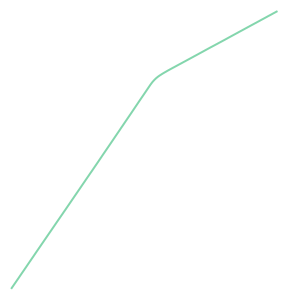

In [61]:
landings_orly_6[0]

In [32]:
len(unique_aircraft)

125

In [16]:
new_aircrafts = data["icao24"].map(lambda icao24: aircraft[icao24])
new_aircrafts

KeyboardInterrupt: 

In [15]:
set(a["model"] for a in aircrafts)

TypeError: 'NoneType' object is not subscriptable

# From all the landings / take_offs in orly 

In [1]:
from traffic.data import opensky

In [3]:
from traffic.core.structure import Airport

In [8]:
from traffic.data import eurofirs

In [ ]:
from traffic.data import airports, nm_airspaces

In [13]:
airports["LFPO"].map_leaflet()

Map(center=[48.72333, 2.37944], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

In [11]:
eurofirs["LFBB"].map_leaflet()

Map(center=[44.856576446393404, 0.7021836137580909], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [6]:

import datetime

start = datetime.datetime(2024,3,1)
end = datetime.datetime(2024,9,30)

print(f"|-- Start = {start}, End = {end} --|")

try:
    landings_orly = opensky.history(
        start=start,
        #stop=end,
        arrival_airport="LFPO",
        bounds = Airport['LFPO'],
    )
    print("Data loaded successfully")
except Exception as e:
    print(f"Error: {e}")

|-- Start = 2024-03-01 00:00:00, End = 2024-09-30 00:00:00 --|
Error: cannot unpack non-iterable property object


In [ ]:

import datetime

start = datetime.datetime(2024,3,1)
end = datetime.datetime(2024,9,30)

print(f"|-- Start = {start}, End = {end} --|")

try:
    landings_orly = opensky.history(
        start=start,
        stop=end,
        arrival_airport="LFPO"
    )
    print("Data loaded successfully")
except Exception as e:
    print(f"Error: {e}")

|-- Start = 2024-03-01 00:00:00, End = 2024-09-30 00:00:00 --|


RUNNING: : 70.6% [00:13, 5.07%/s]
DOWNLOAD: 2.95Mlines [08:42, 5.49klines/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fd30d75d7b0>>
Traceback (most recent call last):
  File "/home/arnault/traffic/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
DOWNLOAD: 3.00Mlines [08:51, 5.61klines/s]

In [3]:
landings_orly.to_pickle(filename="/home/arnault/traffic/data_orly/data/unprocessed/landing_orly_2024.pkl")

In [7]:
len(landings_orly)

317

In [51]:
import traffic

traffic.config_file

PosixPath('/home/arnault/.config/traffic/traffic.conf')

In [1]:
from traffic.data import opensky
flight = opensky.history(
    "2017-02-05 15:45",
    stop="2017-02-05 16:45",
    callsign="EZY158T",
    # returns a Flight instead of a Traffic
    return_flight=True
)
flight

ProgrammingError: (trino.exceptions.TrinoUserError) TrinoUserError(type=USER_ERROR, name=PERMISSION_DENIED, message="Access Denied: Cannot view query", query_id=20250312_155041_35158_m444c)
[SQL: SELECT state_vectors_data4.time, state_vectors_data4.icao24, state_vectors_data4.lat, state_vectors_data4.lon, state_vectors_data4.velocity, state_vectors_data4.heading, state_vectors_data4.vertrate, state_vectors_data4.callsign, state_vectors_data4.onground, state_vectors_data4.alert, state_vectors_data4.spi, state_vectors_data4.squawk, state_vectors_data4.baroaltitude, state_vectors_data4.geoaltitude, state_vectors_data4.lastposupdate, state_vectors_data4.lastcontact, state_vectors_data4.serials, state_vectors_data4.hour 
FROM state_vectors_data4 
WHERE state_vectors_data4.callsign = ? AND state_vectors_data4.time >= ? AND state_vectors_data4.time <= ? AND state_vectors_data4.hour >= ? AND state_vectors_data4.hour < ?]
[parameters: ('EZY158T ', 1486309500, 1486313100, 1486306800, 1486314000)]
(Background on this error at: https://sqlalche.me/e/20/f405)

### Plotting

In [8]:
from cartes.crs import Lambert93
from traffic.data import airports

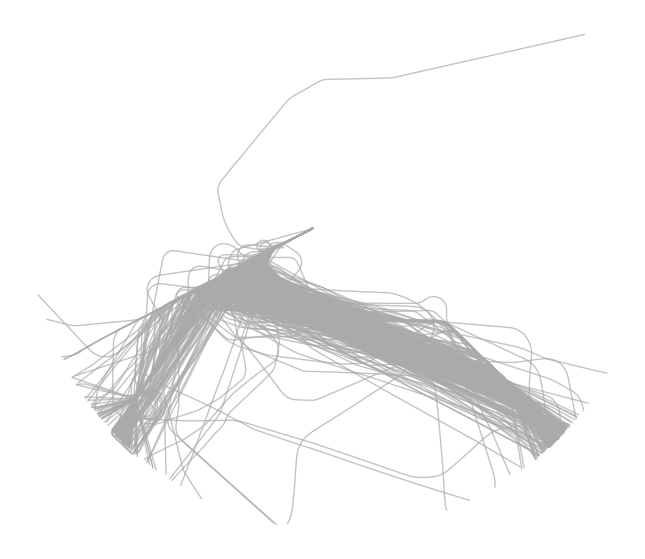

In [10]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(subplot_kw=dict(projection=Lambert93()))
    landings_orly_6[:1000].plot(ax, alpha=.7)

In [1]:
landings_orly_6[0]

NameError: name 'landings_orly_6' is not defined

In [2]:
from traffic.core import Traffic
landings_orly_7_1 = Traffic.from_file("/home/arnault/traffic/data_orly/data/takeoffs_LFPO_07.pkl")


In [3]:
landings_orly_7_1

,count
flight_id,
AEA009_000,200
AEA37YM_001,200
AEA37YM_002,200
AEA37YM_003,200
AEA37YM_004,200
AEA37YM_005,200
AEA37YM_006,200
AEA37YM_007,200
AEA37YM_008,200


In [52]:
flight_0 = landings_orly_7_1[0]

In [5]:
flight_0.aircraft

Tail(icao24='3451cf', registration='EC-MIH', typecode='B788', flag='🇪🇸')

In [71]:
flight_0.vertical_rate_mean

2933.12

In [73]:
flight_0.data["vertical_rate"].iloc[1:].mean()

2930.4924623115576

In [54]:
flight_0.data.head()

,timestamp,altitude,callsign,groundspeed,icao24,latitude,longitude,origin,squawk,track,vertical_rate,flight_id,distance,track_unwrapped,x,y,timedelta
0,2022-07-12 12:46:36+00:00,3175.0,AEA009,162.0,3451cf,48.735957,2.449445,LFPO,7671,73.909184,3456.0,AEA009_000,1.950662,73.909184,18462.83807,5418944.374075,0
1,2022-07-12 12:46:38+00:00,3250.0,AEA009,163.0,3451cf,48.736359,2.451501,LFPO,7671,74.006416,3328.0,AEA009_000,2.035768,74.006416,18617.689568,5418975.980746,2
2,2022-07-12 12:46:42+00:00,3500.0,AEA009,166.0,3451cf,48.737183,2.456008,LFPO,7671,74.240478,3072.0,AEA009_000,2.221493,74.240478,18956.716023,5419038.934526,6
3,2022-07-12 12:46:44+00:00,3575.0,AEA009,169.0,3451cf,48.737686,2.458684,LFPO,7671,74.240478,2880.0,AEA009_000,2.331994,74.240478,19158.144992,5419077.911651,8
4,2022-07-12 12:46:48+00:00,3750.0,AEA009,176.0,3451cf,48.738464,2.462909,LFPO,7671,74.144199,2368.0,AEA009_000,2.506198,74.144199,19476.021654,5419137.595691,12


In [55]:
flight_0.data["vertical_rate"].min()

1920.0

In [56]:
data = flight_0.data
data = data.drop(columns=['vertical_rate'])

In [57]:
new_traffic = Traffic(data)
test = new_traffic.filter('aggressive')

In [58]:
test = test.eval()

In [59]:
flight_0.data.head()

,timestamp,altitude,callsign,groundspeed,icao24,latitude,longitude,origin,squawk,track,vertical_rate,flight_id,distance,track_unwrapped,x,y,timedelta
0,2022-07-12 12:46:36+00:00,3175.0,AEA009,162.0,3451cf,48.735957,2.449445,LFPO,7671,73.909184,3456.0,AEA009_000,1.950662,73.909184,18462.83807,5418944.374075,0
1,2022-07-12 12:46:38+00:00,3250.0,AEA009,163.0,3451cf,48.736359,2.451501,LFPO,7671,74.006416,3328.0,AEA009_000,2.035768,74.006416,18617.689568,5418975.980746,2
2,2022-07-12 12:46:42+00:00,3500.0,AEA009,166.0,3451cf,48.737183,2.456008,LFPO,7671,74.240478,3072.0,AEA009_000,2.221493,74.240478,18956.716023,5419038.934526,6
3,2022-07-12 12:46:44+00:00,3575.0,AEA009,169.0,3451cf,48.737686,2.458684,LFPO,7671,74.240478,2880.0,AEA009_000,2.331994,74.240478,19158.144992,5419077.911651,8
4,2022-07-12 12:46:48+00:00,3750.0,AEA009,176.0,3451cf,48.738464,2.462909,LFPO,7671,74.144199,2368.0,AEA009_000,2.506198,74.144199,19476.021654,5419137.595691,12


In [60]:
test.data.head()

,timestamp,altitude,callsign,groundspeed,icao24,latitude,longitude,origin,squawk,track,flight_id,distance,track_unwrapped,x,y,timedelta
0,2022-07-12 12:46:36+00:00,3175.0,AEA009,162.000000,3451cf,48.735957,2.449445,LFPO,7671,73.909184,AEA009_000,1.950662,73.909184,18462.83807,5418944.374075,0
1,2022-07-12 12:46:38+00:00,3250.0,AEA009,163.000000,3451cf,48.736359,2.451501,LFPO,7671,74.019933,AEA009_000,2.035768,74.006416,18617.689568,5418975.980746,2
2,2022-07-12 12:46:42+00:00,3500.0,AEA009,166.000000,3451cf,48.737183,2.456008,LFPO,7671,74.098271,AEA009_000,2.221493,74.240478,18956.716023,5419038.934526,6
3,2022-07-12 12:46:44+00:00,3575.0,AEA009,171.000000,3451cf,48.737686,2.458684,LFPO,7671,74.144199,AEA009_000,2.331994,74.240478,19158.144992,5419077.911651,8
4,2022-07-12 12:46:48+00:00,3750.0,AEA009,174.571429,3451cf,48.738464,2.462909,LFPO,7671,74.069850,AEA009_000,2.506198,74.144199,19476.021654,5419137.595691,12


In [46]:
from traffic.core import Flight
def compute_vertical_rate_flight(flight : Flight) -> Flight:
        data = flight.data
        delta_time = data["timedelta"].diff()
        delta_altitude = data["altitude"].diff()
        data["vertical_rate"] = delta_altitude / delta_time *60
        data.loc[data.index[0], "vertical_rate"] = data["vertical_rate"].iloc[1]
        return Flight(data)


def compute_vertical_rate(traffic: Traffic) -> Traffic:
    return traffic.iterate_lazy().pipe(compute_vertical_rate_flight).eval()  

In [47]:
#computed_vertical_rate
flight_computed = compute_vertical_rate_flight(flight_0)

In [48]:
flight_computed.vertical_rate_mean

2775.9375

In [66]:
from traffic.algorithms.filters.kalman import KalmanFilter6D
new_t = flight_computed.filter()

In [67]:
new_t.data.head()

,timestamp,altitude,callsign,groundspeed,icao24,latitude,longitude,origin,squawk,track,vertical_rate,flight_id,distance,track_unwrapped,x,y,timedelta
0,2022-07-12 12:46:36+00:00,3175.0,AEA009,162.0,3451cf,48.735957,2.449445,LFPO,7671,74.144199,2250.0,AEA009_000,1.950662,73.909184,18462.83807,5418944.374075,0
1,2022-07-12 12:46:38+00:00,3250.0,AEA009,163.0,3451cf,48.736359,2.451501,LFPO,7671,74.144199,2250.0,AEA009_000,2.035768,74.006416,18617.689568,5418975.980746,2
2,2022-07-12 12:46:42+00:00,3500.0,AEA009,166.0,3451cf,48.737183,2.456008,LFPO,7671,74.144199,2625.0,AEA009_000,2.221493,74.240478,18956.716023,5419038.934526,6
3,2022-07-12 12:46:44+00:00,3575.0,AEA009,169.0,3451cf,48.737686,2.458684,LFPO,7671,74.144199,2625.0,AEA009_000,2.331994,74.240478,19158.144992,5419077.911651,8
4,2022-07-12 12:46:48+00:00,3750.0,AEA009,176.0,3451cf,48.738464,2.462909,LFPO,7671,74.144199,2625.0,AEA009_000,2.506198,74.144199,19476.021654,5419137.595691,12


In [69]:
flight_computed.data.head()

,timestamp,altitude,callsign,groundspeed,icao24,latitude,longitude,origin,squawk,track,vertical_rate,flight_id,distance,track_unwrapped,x,y,timedelta
0,2022-07-12 12:46:36+00:00,3175.0,AEA009,162.0,3451cf,48.735957,2.449445,LFPO,7671,73.909184,2250.0,AEA009_000,1.950662,73.909184,18462.83807,5418944.374075,0
1,2022-07-12 12:46:38+00:00,3250.0,AEA009,163.0,3451cf,48.736359,2.451501,LFPO,7671,74.006416,2250.0,AEA009_000,2.035768,74.006416,18617.689568,5418975.980746,2
2,2022-07-12 12:46:42+00:00,3500.0,AEA009,166.0,3451cf,48.737183,2.456008,LFPO,7671,74.240478,3750.0,AEA009_000,2.221493,74.240478,18956.716023,5419038.934526,6
3,2022-07-12 12:46:44+00:00,3575.0,AEA009,169.0,3451cf,48.737686,2.458684,LFPO,7671,74.240478,2250.0,AEA009_000,2.331994,74.240478,19158.144992,5419077.911651,8
4,2022-07-12 12:46:48+00:00,3750.0,AEA009,176.0,3451cf,48.738464,2.462909,LFPO,7671,74.144199,2625.0,AEA009_000,2.506198,74.144199,19476.021654,5419137.595691,12


In [70]:
flight_computed.vertical_rate_mean

2775.9375

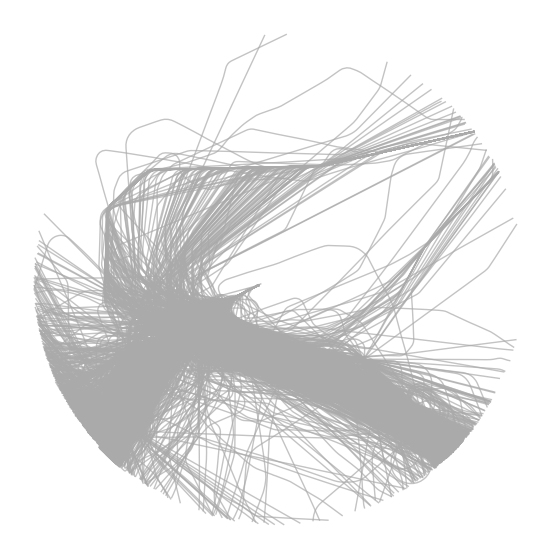

In [6]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(subplot_kw=dict(projection=Lambert93()))
    landings_orly_6.plot(ax, alpha=.7)

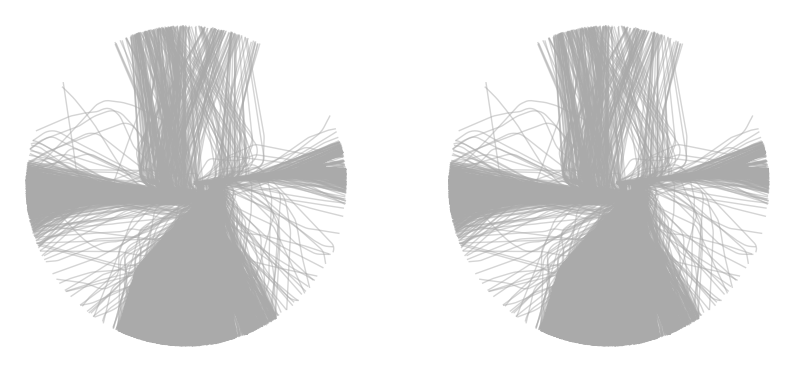

In [13]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(1,2,subplot_kw=dict(projection=Lambert93()))
    landings_orly_7_1.plot(ax[0], alpha=.5) 
    landings_orly_7_2.plot(ax[1], alpha=.5) 

In [ ]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(subplot_kw=dict(projection=Lambert93()))
    landings_orly_7_2.plot(ax, alpha=.7) 

    